## Step 1 

So the idea right now is that, we take the UK temprature database and remove some coastal points using those coastal points that we have removed we try to conduct imputation. So for that we need to identify the points by the coast and later remove a sample of them and try to conduct imputation on the sample that we have removed. 

### Raster Temprature Data to vector polygons 

In [ ]:
import rasterio
import numpy as np

def process_geotiff(input_file, output_file):
    # Open the input TIFF file
    with rasterio.open(input_file) as src:
        # Read the data from the first band
        data = src.read(1)
        
        # Set negative and zero values to NaN
        data[data == 0] = np.nan
        
        # Update the metadata to handle NaN values correctly
        profile = src.profile
        profile.update(
            dtype=rasterio.float32,  # Ensure data type can handle NaN
            nodata=np.nan            # Define nodata value
        )
        
        # Write the modified data to a new TIFF file
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(data, 1)

# Define input and output file paths
input_file = 'UK_DEM_merged.tif'
output_file = 'UK_DEM2.tif'

# Process the TIFF file
process_geotiff(input_file, output_file)

In [2]:
import rasterio
from shapely.geometry import Point, box
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm import tqdm

# Path to your GeoTIFF file
input_file = 'precipitation_sum.tif' # file made by romving -99 values from temprature data 

# Open the GeoTIFF file
with rasterio.open(input_file) as src:
    # Read the entire raster data into memory
    data = src.read(1)
    
    # Get the nodata value
    nodata_value = src.nodata

    # Create a mask for valid data points (including zero values)
    mask = (data != nodata_value) & ~np.isnan(data)
    
    # Get the row and column indices of valid data points
    row_indices, col_indices = np.where(mask)
    
    # Get the pixel values of the valid data points
    values = data[mask]
    
    # Initialize lists to store coordinates, values, and bounds
    lons, lats, x_mins, y_mins, x_maxs, y_maxs = [], [], [], [], [], []
    
    # Get pixel size (resolution)
    pixel_size_x, pixel_size_y = src.res
    
    # Iterate with progress tracking
    for row, col in tqdm(zip(row_indices, col_indices), total=len(row_indices), desc="Processing"):
        lon, lat = src.xy(row, col)
        lons.append(lon)
        lats.append(lat)
        x_min, y_min = lon - pixel_size_x / 2, lat - pixel_size_y / 2
        x_max, y_max = lon + pixel_size_x / 2, lat + pixel_size_y / 2
        x_mins.append(x_min)
        y_mins.append(y_min)
        x_maxs.append(x_max)
        y_maxs.append(y_max)

# Create a DataFrame from the valid points
df = pd.DataFrame({
    'longitude': lons,
    'latitude': lats,
    'value': values,
    'x_min': x_mins,
    'y_min': y_mins,
    'x_max': x_maxs,
    'y_max': y_maxs
})

# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry=[box(x_min, y_min, x_max, y_max) for x_min, y_min, x_max, y_max in zip(df.x_min, df.y_min, df.x_max, df.y_max)], crs=src.crs)

# Save the GeoDataFrame as a shapefile
output_shapefile = 'precipitation_squares.shp'
gdf.to_file(output_shapefile)

print(f"Shapefile saved successfully: {output_shapefile}")


Processing:   0%|          | 0/1707 [00:00<?, ?it/s]

Processing: 100%|██████████| 1707/1707 [00:00<00:00, 23674.30it/s]


Shapefile saved successfully: precipitation_squares.shp


Highlighting Polygons that are coastal (Idea if a square touches 7 or more squares it is landbased point )

Need to Read algorithm how R tree is working

In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Function to extract points from a square's coordinates
def extract_points(row):
    """Extracts the four corner points from a row of the GeoDataFrame."""
    x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
    return set([
        (x_min, y_min),
        (x_max, y_min),
        (x_min, y_max),
        (x_max, y_max)
    ])

# Function to classify a square based on its points
def classify_square(row, all_squares):
    """Classify a square as 'inland' or 'coastal'."""
    points = extract_points(row)
    matching_count = 0
    
    # Compare this square's points with all other squares
    for other_index, other_row in all_squares.iterrows():
        if row.name == other_index:
            continue
        
        other_points = extract_points(other_row)
        # Count how many points match
        if len(points.intersection(other_points)) > 0:
            matching_count += 1
        
        # Early exit if enough matches are found
        if matching_count >= 7:
            return 'inland'
    
    return 'coastal'

# Load your shapefile into a GeoDataFrame
input_shapefile = 'precipitation_squares.shp'
gdf = gpd.read_file(input_shapefile)

# Classify each square
gdf['classification'] = gdf.apply(lambda row: classify_square(row, gdf), axis=1)

# Save the classified GeoDataFrame to a new shapefile
output_shapefile = 'classified_squares_sides_7.shp'
gdf.to_file(output_shapefile)

print(f"Classified shapefile saved successfully: {output_shapefile}")


C:\Users\VIBBAT\AppData\Local\Temp\ipykernel_17740\2425215990.py:46: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)


Classified shapefile saved successfully: classified_squares_sides_7.shp


In [8]:
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the shapefile
input_shapefile = 'classified_squares_sides_7.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Determine the number of coastal points to delete (10%)
num_to_delete = int(len(coastal_points) * 0.15)

# Randomly select 10% of the coastal points
coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=450)

# Create a training dataset by dropping the selected coastal points
training_data = gdf.drop(coastal_to_delete.index)

# Save the training dataset to a new shapefile
training_shapefile = 'training_data.shp'
training_data.to_file(training_shapefile)

# Save the deleted coastal points to a new shapefile for imputation
imputation_shapefile = 'imputation_data.shp'
coastal_to_delete.to_file(imputation_shapefile)

print(f"Training data saved to: {training_shapefile}")
print(f"Imputation data saved to: {imputation_shapefile}")


Training data saved to: training_data.shp
Imputation data saved to: imputation_data.shp


Lets Try KNN 

k=1, MSE=58469.51877005377
k=2, MSE=30626.83892054715
k=3, MSE=35374.52722982919
k=4, MSE=48351.34386245618
k=5, MSE=64502.060599502256
k=6, MSE=76509.16413403147
k=7, MSE=71818.23879901672
k=8, MSE=75549.52398411583
k=9, MSE=78716.64318294014
Imputed shapefile saved successfully: imputed_file1.shp


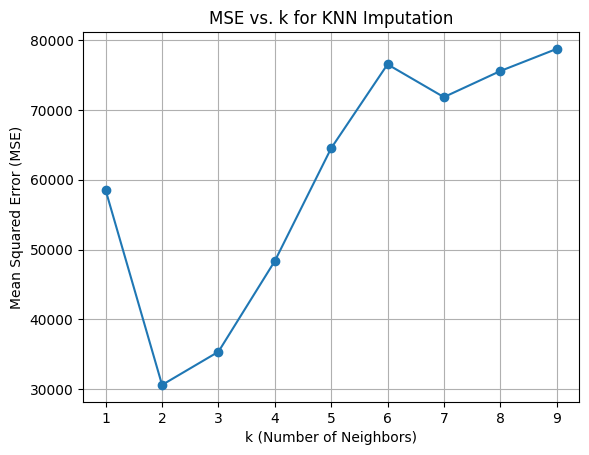

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the shapefiles
file1 = 'imputation_data.shp'  # Imputation points with missing values
file2 = 'training_data.shp'  # Reference data

gdf1 = gpd.read_file(file1)
gdf2 = gpd.read_file(file2)

'''
# Ensure the datasets are aligned based on coordinates (longitude and latitude)
gdf1['longitude'] = gdf1.geometry.x
gdf1['latitude'] = gdf1.geometry.y
gdf2['longitude'] = gdf2.geometry.x
gdf2['latitude'] = gdf2.geometry.y
'''
# Extract relevant columns for imputation
df1 = gdf1[['longitude', 'latitude', 'value']]
df2 = gdf2[['longitude', 'latitude', 'value']]

# Prepare the KNN regressor
def impute_knn(df_missing, df_reference, k):
    # Fit the KNN regressor on the reference data
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_reference[['longitude', 'latitude']], df_reference['value'])

    # Predict the missing values
    imputed_values = knn.predict(df_missing[['longitude', 'latitude']])
    return imputed_values

# Define the range of k values to test
k_values = range(1, 10)
mse_values = []

# Perform KNN imputation and calculate MSE for each k
for k in k_values:
    imputed_values = impute_knn(df1, df2, k)
    mse = mean_squared_error(df1['value'], imputed_values)
    mse_values.append(mse)
    print(f'k={k}, MSE={mse}')

    # Add the imputed values to the original GeoDataFrame
    gdf1[f'imp_val_{k}'] = imputed_values

# Save the modified GeoDataFrame to a new shapefile
output_shapefile = 'imputed_file1.shp'
gdf1.to_file(output_shapefile)
print(f"Imputed shapefile saved successfully: {output_shapefile}")

# Plot MSE values
plt.plot(k_values, mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. k for KNN Imputation')
plt.grid(True)
plt.show()


In [17]:
print(all_mse_values)

[[0.0661098226215451, 0.047896568782167505, 0.048142821538219395, 0.054465657113613446, 0.06877285033675147, 0.07192997220743569, 0.08210601006556947, 0.09013350413863043, 0.10185307235480348], [0.0710840713179131, 0.03931873128233067, 0.03869124583638916, 0.05602991493980898, 0.054846212684511064, 0.06718989910311603, 0.07409175210958302, 0.08389219823860143, 0.09498322609391385], [0.06382998477800716, 0.04475187066227667, 0.04763847444780372, 0.05863023929067454, 0.0672805715999391, 0.0721765569238256, 0.08572869251707509, 0.09655698037031574, 0.10007340809410616], [0.06093548120042071, 0.030965055155135528, 0.037846437968337095, 0.04681809911534453, 0.05517934019236492, 0.05962654770441467, 0.06898333701998091, 0.07997312119323627, 0.08768637502659035], [0.06908154565201519, 0.035837177540348354, 0.04599262692067756, 0.05659148662530243, 0.07344568916370801, 0.07908534190416898, 0.08994862123652403, 0.10782759904622852, 0.11539822167113009], [0.05779362470141564, 0.04324069013864575

Processing Runs: 100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


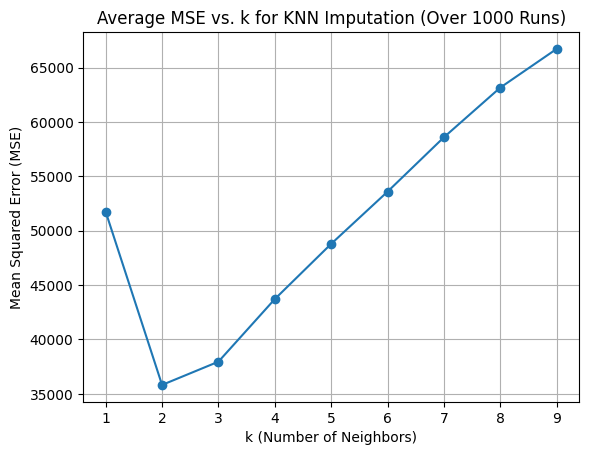

Average MSE results saved successfully: average_mse_results.csv


In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the shapefile
input_shapefile = 'classified_squares_sides_7.shp'
gdf = gpd.read_file(input_shapefile)

# Filter coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Function to perform KNN imputation and calculate MSE
def perform_imputation(random_state):
    # Determine the number of coastal points to delete (15%)
    num_to_delete = int(len(coastal_points) * 0.3)

    # Randomly select 30% of the coastal points
    coastal_to_delete = coastal_points.sample(n=num_to_delete, random_state=random_state)

    # Create a training dataset by dropping the selected coastal points
    training_data = gdf.drop(coastal_to_delete.index)

    # Prepare the datasets for KNN
    gdf1 = coastal_to_delete.copy()
    gdf2 = training_data.copy()
    # Extract relevant columns for imputation
    df1 = gdf1[['longitude', 'latitude', 'value']]
    df2 = gdf2[['longitude', 'latitude', 'value']]

    # Define the range of k values to test
    k_values = range(1, 10)  # Ensuring this matches in both functions
    mse_values = np.zeros(len(k_values))  # Initialize an array to store MSE for each k

    # Perform KNN imputation and calculate MSE for each k
    for idx, k in enumerate(k_values):
        imputed_values = impute_knn(df1, df2, k)
        mse = mean_squared_error(df1['value'], imputed_values)
        mse_values[idx] += mse  # Sum the MSE values

    return mse_values

# Prepare the KNN regressor function
def impute_knn(df_missing, df_reference, k):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_reference[['longitude', 'latitude']], df_reference['value'])
    imputed_values = knn.predict(df_missing[['longitude', 'latitude']])
    return imputed_values

# Number of iterations with different random states
num_iterations = 1000
k_values = range(1, 10)  # Define the k values
cumulative_mse_values = np.zeros(len(k_values))  # Initialize an array to store cumulative MSE

# Perform imputation for different random states and collect MSE values
for i in tqdm(range(num_iterations), desc="Processing Runs"):
    # Generate a random seed value for additional randomness
    random_seed = random.randint(0, 100000)
    random_state = (i * 2 )+ random_seed
    mse_values = perform_imputation(random_state=random_state)
    cumulative_mse_values += mse_values

# Calculate the average MSE for each k value
average_mse_values = cumulative_mse_values / num_iterations

# Plot average MSE values
plt.plot(k_values, average_mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'Average MSE vs. k for KNN Imputation (Over {num_iterations} Runs)')
plt.grid(True)
plt.show()

# Save the results
results = pd.DataFrame({
    'k': k_values,
    'average_mse': average_mse_values
})
results.to_csv('average_mse_results.csv', index=False)
print(f"Average MSE results saved successfully: average_mse_results.csv")


In [37]:
print(results)

   k  average_mse
0  1     0.076917
1  2     0.054487
2  3     0.059350
3  4     0.070649
4  5     0.081482
5  6     0.092347
6  7     0.103572
7  8     0.113566
8  9     0.122988


In [28]:
print(results)

   k  average_mse
0  1     0.077492
1  2     0.054585
2  3     0.059626
3  4     0.071120
4  5     0.081944
5  6     0.092901
6  7     0.104192
7  8     0.114108
8  9     0.123704


### Further Ideas 


Problem is when you apply Land Sea mask simulation data is lost along coast 
Same should happen when you apply land sea mask 



Thing is simple KNN can do that also probabbly along a simple time scale just use neighbours value and fit the data (thing with KNN is there is no training data or anything its just weightage so read how this KNN is working)

(Also tried removing island area coastal points but results were still kind of promising, in some cases while in some cases like lat 798000.000 long 138000.000 (I.e small isle national scenic area ) imputation gave value of MSE 0.45 best case (2 neighbours)  Since all the neighbours were having extremely diffrent conditions so it the following is really dependent on value of neighbouring data which is not the most reliable, therefore ) 

See how well do other methods also compare to KNN 


Check with Precipitation Data too 
Need to prepare that data set. 



Validation Strat improval 
1) Remove from existing and fit into the unkonw  points 
2) Check with removed simulated and see how do removed ones fit 
3) Bias correct with observational to check.

### Further Readings

Simulated data sets read UKCP (how does their model work)

Read more about weather dasta sets 

Read on imputation methods (obviously)
